<a href="https://colab.research.google.com/github/jjgranadat/Semillero_SOFA/blob/Santiago_V/k_Means_16QAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn import metrics

# Generación y modulación

In [43]:
Ns= 10000
Mod=16 #16QAM
Symbols_tx = np.random.randint(Mod, size=Ns)
df_sym_tx= pd.DataFrame(Symbols_tx)
print(Symbols_tx[0:10])

[11  5  6 11  6  0  1 11 15  7]


In [44]:
mod_dict = {0:-3+3j, #0000
            1:-3+1j, #0001
            2:-3-3j, #0010
            3:-3-1j, #0011
            4:-1+3j, #0100
            5:-1+1j, #0101
            6:-1-3j, #0110
            7:-1-1j, #0111
            8:3+3j, #1000
            9:3+1j, #1001
            10:3-3j, #1010
            11:3-1j, #1011
            12:1+3j, #1100
            13:1+1j, #1101
            14:1-3j, #1110
            15:1-1j} #1111

In [45]:
#Modulación reemplazando símbolos por valores complejos - mapeo (opción 2)
df_sym_mod2 = df_sym_tx.iloc[:,0].map(mod_dict)
df_sym_mod2.head(20)

0     3.0-1.0j
1    -1.0+1.0j
2    -1.0-3.0j
3     3.0-1.0j
4    -1.0-3.0j
5    -3.0+3.0j
6    -3.0+1.0j
7     3.0-1.0j
8     1.0-1.0j
9    -1.0-1.0j
10   -3.0+3.0j
11   -3.0-1.0j
12    3.0-3.0j
13   -1.0+1.0j
14   -3.0+1.0j
15    1.0-3.0j
16    3.0+3.0j
17    1.0+3.0j
18   -3.0-3.0j
19   -1.0-1.0j
Name: 0, dtype: complex128

# Transmisión canal AWGN

In [46]:
Xr = np.real(df_sym_mod2)
Xi = np.imag(df_sym_mod2)

In [47]:
# Adición de ruido blanco Gaussiano (AWGN)

target_snr_db = 15
Xr_avg_p = np.mean(Xr**2)
Xr_avg_db = 10 * np.log10(Xr_avg_p)
#print(Xr_avg_db)
noise_avg_db_r = Xr_avg_db - target_snr_db
noise_avg_p_r = 10 ** (noise_avg_db_r / 10)
mean_noise = 0
noise_r = np.random.normal(mean_noise, np.sqrt(noise_avg_p_r), len(Xr))
Xr_ch = Xr + noise_r

Xi_avg_p = np.mean(Xi**2)
Xi_avg_db = 10 * np.log10(Xi_avg_p)
#print(Xi_avg_db)
noise_avg_db_i = Xr_avg_db - target_snr_db
noise_avg_p_i = 10 ** (noise_avg_db_i / 10)
noise_i = np.random.normal(mean_noise, np.sqrt(noise_avg_p_i), len(Xi))
Xi_ch = Xi + noise_i

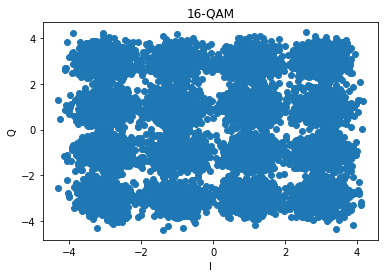

In [48]:
plt.plot(Xi_ch, Xr_ch, 'o')
plt.xlabel('I')
plt.ylabel('Q')
plt.title('16-QAM')
plt.show()

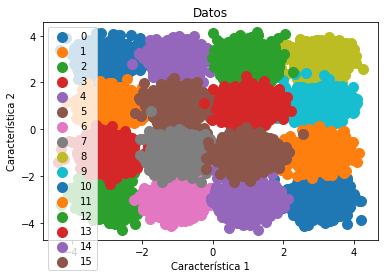

In [49]:
fig, ax = plt.subplots()
for g in np.unique(Symbols_tx):
    ix = np.where(Symbols_tx == g)
    ax.scatter(Xr_ch[ix], Xi_ch[ix], label = g, s = 100)
ax.legend()
plt.xlabel('Característica 1')
plt.ylabel('Característica 2')
plt.title('Datos')
plt.show()

# Demodulación

In [50]:
def demapper_sym(symbols_I, symbols_Q, Ns, threshold = 2.0):
   symbol = []
   for i in range(Ns):
        if symbols_I[i] <= -threshold and symbols_Q[i] >= threshold: #-3+3j
            symbol.append(0)
        elif symbols_I[i] <= -threshold and symbols_Q[i] >= 0 and symbols_Q[i] <= threshold: #-3+1j
            symbol.append(1)
        elif symbols_I[i] <= -threshold and symbols_Q[i] <= 0 and symbols_Q[i] >= -threshold: #-3-j
            symbol.append(3)
        elif symbols_I[i] <= -threshold and symbols_Q[i] <= -threshold: #-3-3j
            symbol.append(2)
        elif symbols_I[i] >= -threshold and symbols_I[i] <= 0 and symbols_Q[i] >= threshold: #-1+3j
            symbol.append(4)
        elif symbols_I[i] >= -threshold and symbols_I[i] <= 0 and symbols_Q[i] >= 0 and symbols_Q[i] <= threshold: #-1+j
            symbol.append(5)
        elif symbols_I[i] >= -threshold and symbols_I[i] <= 0 and symbols_Q[i] <= 0 and symbols_Q[i] >= -threshold: #-1-j
            symbol.append(7)
        elif symbols_I[i] >= -threshold and symbols_I[i] <= 0 and symbols_Q[i] <= -threshold: #-1-3j
            symbol.append(6)
        elif symbols_I[i] >= 0 and symbols_I[i] <= threshold and symbols_Q[i] >= threshold: #1+3j
            symbol.append(12)
        elif symbols_I[i] >= 0 and symbols_I[i] <= threshold and symbols_Q[i] >= 0 and symbols_Q[i] <= threshold: #1+j
            symbol.append(13)
        elif symbols_I[i] >= 0 and symbols_I[i] <= threshold and symbols_Q[i] <= 0 and symbols_Q[i] >= -threshold: #1-j
            symbol.append(15)
        elif symbols_I[i] >= 0 and symbols_I[i] <= threshold and symbols_Q[i] <= -threshold: #1-3j
            symbol.append(14)
        elif symbols_I[i] >= threshold and symbols_Q[i] >= threshold: #3+3j
            symbol.append(8)
        elif symbols_I[i] >= threshold and symbols_Q[i] >= 0 and symbols_Q[i] <= threshold: #3+1j
            symbol.append(9)
        elif symbols_I[i] >= threshold and symbols_Q[i] <= 0 and symbols_Q[i] >= -threshold: #3-1j
            symbol.append(11)
        elif symbols_I[i] >= threshold and symbols_Q[i] <= -threshold: #3-3j
            symbol.append(10)
   return(symbol)

In [51]:
sym_rx= demapper_sym(Xr_ch, Xi_ch, len(Xr_ch), threshold = 2.0)
print(sym_rx[0:10])

[11, 5, 6, 11, 6, 0, 1, 11, 15, 7]


In [52]:
def SER_f(sym_rx, Symbols_tx, Ns):
    error = 0
    for i in range(Ns):
        if sym_rx[i] == Symbols_tx[i]:
            error = error
        else:
            error= error + 1
    SER = error/Ns
    return([SER, error])

In [53]:
SER, error = SER_f(sym_rx, Symbols_tx, Ns)
print(SER)
print(error)

0.0178
178


# Demodulación usando K-Means

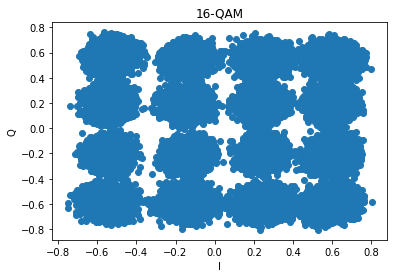

In [62]:
with open("partreal.txt", "r") as datar:
    linesr = datar.read().split(',')
Xr_mat = []
for line in linesr:
    Xr_mat.append(float(line))

with open("part_imag.txt", "r") as datai:
    linesi = datai.read().split(',')
Xi_mat = []
for line in linesi:
    Xi_mat.append(float(line))
plt.plot(Xi_mat, Xr_mat, 'o')
plt.xlabel('I')
plt.ylabel('Q')
plt.title('16-QAM')
plt.show()

In [63]:
X = np.transpose(np.array([Xr_mat,Xi_mat]))
y= Symbols_tx

In [64]:
model = KMeans(n_clusters = 16)
model.fit(X)

KMeans(n_clusters=16)

In [65]:
model.labels_

array([ 4,  7, 11, ..., 13,  6,  9], dtype=int32)

In [40]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey = True, figsize = (10, 5))
ax1.set_title('k-Means')
ax1.scatter(X[:,0],X[:,1], c=model.labels_)
ax2.set_title('Original')
ax2.scatter(X[:,0],X[:,1], c=y)

ValueError: ignored

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f464eb7f8b0> (for post_execute):


KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7f464da6c4c0> (for post_execute):


KeyboardInterrupt: ignored

In [17]:
SER_test, error_test = SER_f(model.labels_, y, len(y))

In [18]:
print(SER_test)
print(error_test)

0.939
9390


In [19]:
cen_init= np.array([[-3,3], [-3,1], [-3,-3],[-3,-1],[-1,3],[-1,1],[-1,-3],[-1,-1],[3,3],[3,1],[3,-3],[3,-1],[1,3],[1,1],[1,-3],[1,-1]])

In [20]:
model2 = KMeans(n_clusters = 16, init=cen_init)
model2.fit(X)

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


KMeans(init=array([[-3,  3],
       [-3,  1],
       [-3, -3],
       [-3, -1],
       [-1,  3],
       [-1,  1],
       [-1, -3],
       [-1, -1],
       [ 3,  3],
       [ 3,  1],
       [ 3, -3],
       [ 3, -1],
       [ 1,  3],
       [ 1,  1],
       [ 1, -3],
       [ 1, -1]]),
       n_clusters=16)

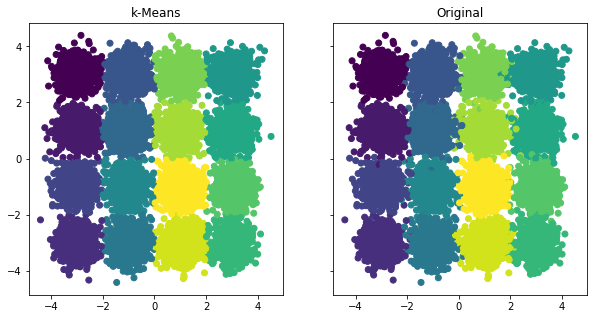

In [21]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey = True, figsize = (10, 5))
ax1.set_title('k-Means')
ax1.scatter(X[:,0],X[:,1], c=model2.labels_)
ax2.set_title('Original')
ax2.scatter(X[:,0],X[:,1], c=y)

In [22]:
SER_test2, error_test2 = SER_f(model2.labels_, y, len(y))

In [23]:
print(SER_test2)
print(error_test2)

0.0171
171
